In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.misc import imread

## 1. Lecture d'une image RGB

In [6]:
img = imread('img/45.jpg')
print('Shape:', img.shape)

Shape: (200, 200, 3)


# 2. Quantification de la couleur

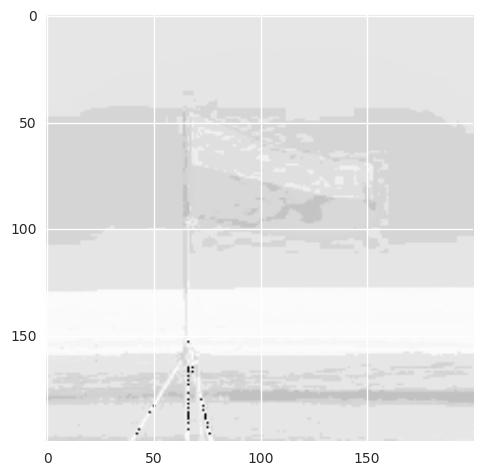

In [80]:
def sample_pixel(pixel):
    to_bits = lambda x: '{0:08b}'.format(x)
    r, g, b = to_bits(pixel[0]), to_bits(pixel[1]), to_bits(pixel[2])
    r_intensity = int(r[0]) * 2 ** 5 + int(r[1]) * 2 ** 4
    g_intensity = int(g[0]) * 2 ** 3 + int(g[1]) * 2 ** 2
    b_intensity = int(b[0]) * 2 ** 1 + int(b[1]) * 2 ** 0
    intensity = r_intensity + g_intensity + b_intensity
    return [intensity, intensity, intensity]


def sample_image(image):
    return [
        [
            sample_pixel(pixel)
            for pixel in row
        ]
        for row in image
    ]


plt.imshow(sample_image(img))

## 3. Histogramme de couleur

<Container object of 64 artists>

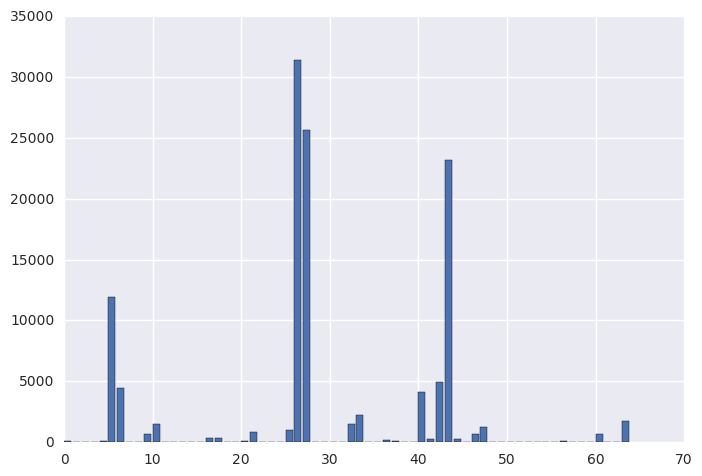

In [81]:
from scipy.ndimage.measurements import histogram


hist = histogram(sample, min=0, max=63, bins=64)

plt.bar([i for i in range(64)], hist)

## 4. Indexation d'image

In [82]:
from os import listdir

histograms = {
    i: histogram(sample_image(imread('img/{}'.format(image_file))), min=0, max=63, bins=64)
    for i, image_file in enumerate(listdir('img/'))
}

## 5. Recherche d'images similaires par la couleur

$d(h_{1},h_{2})=\sum _{i=1}^{N}\min \left[h_{1}(i),h_{2}(i)\right]$

In [95]:
def histogram_intersection(h1, h2):
    return sum(((min(v1, v2) for v1, v2 in zip(h1, h2))))


target_img = 45

neighbours = sorted(histograms.items(), key=lambda x: histogram_intersection(x[1], histograms[target_img]))[-6:]

for neighbour in reversed(neighbours):
    print(neighbour[0])

45
46
12
21
26
43
